![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Linear Regression and Optimization

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/cafawo/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/cafawo/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import optimize

# Read data from CSV file
prices = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)
returns = prices.pct_change()
returns = returns.iloc[1:,::]

### Task:

Find the vector of weights $\mathbf{w}$ for the [Minimum Variance Portfolio (MVP)](https://en.wikipedia.org/wiki/Modern_portfolio_theory) using only the constituents (not .GDAXI). Print risk ($\sigma$) and return ($\mu$) of both, DAX and MVP. Show in a single graph the cumulative log-returns of both portfolios. Please note that the sum of $\mathbf{w}$ must be $100$%. ALso, you are not allowed to use short positions, i.e. $w \ge 0\ \forall\ w \in \mathbf{w}$.

Hint: The portfolio variance - which we want to minimize - is given by
$$
\sigma^2_\text{Portfolio} = \mathbf{w}^\intercal \mathbf{\Sigma} \mathbf{w},
$$
where $\mathbf{\Sigma}$ is the correlation matrix of the portfolio constituents.

MVP: mu = 0.000679, sigma = 0.0073, ratio = 0.093613
DAX: mu = 0.000552, sigma = 0.0121, ratio = 0.045643


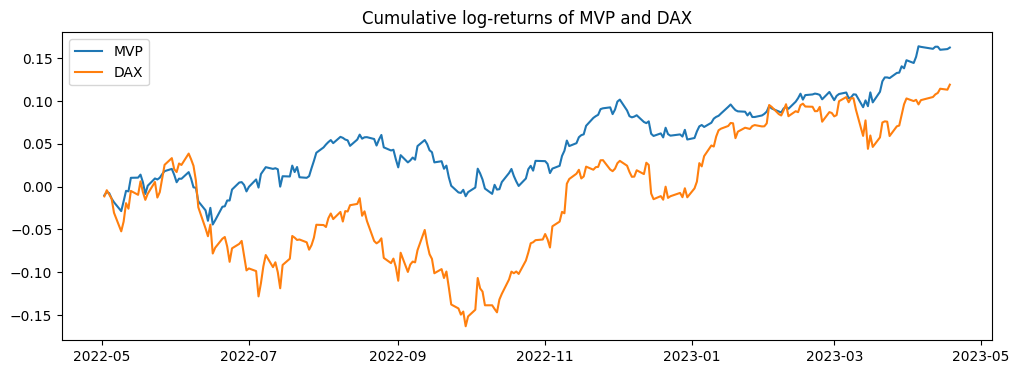

In [4]:
# Covariance matrix
Sigma = returns.iloc[:, 1:].cov().values

# Expected returns
mu = returns.iloc[:, 1:].mean().values

# Number of assets
n = len(mu)

# Objective function: Portfolio variance
def objective(weights):
    return (weights @ Sigma @ weights) * 10000

# Constraints: sum of weights is 100%
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: no short selling, i.e., 0 <= w <= 1 for all weights
bnds = tuple((0, 1) for x in range(n))

# Initial guess: Equal distribution
x0 = np.array(n*[1./n,])

# Minimize function
optimal = optimize.minimize(objective, x0, method='SLSQP', bounds=bnds, constraints=cons)
# Extract the result
weights_MVP = optimal.x

# Calculate risk and return of the MVP
risk_MVP = np.sqrt(weights_MVP @ Sigma @ weights_MVP)  # Portfolio standard deviation
return_MVP = weights_MVP @ mu  # Portfolio return

# Risk and return of the DAX index
risk_DAX = returns.iloc[:, 0].std()
return_DAX = returns.iloc[:, 0].mean()

# Print risk and return
print(f'MVP: mu = {return_MVP:.6f}, sigma = {risk_MVP:.4f}, ratio = {return_MVP/risk_MVP:.6f}')
print(f'DAX: mu = {return_DAX:.6f}, sigma = {risk_DAX:.4f}, ratio = {return_DAX/risk_DAX:.6f}')

# Plot cumulative log-returns
plt.figure(figsize=(12,4))
plt.plot(np.log(1 + returns.iloc[:, 1:] @ weights_MVP).cumsum(), label='MVP')
plt.plot(np.log(1 + returns.iloc[:, 0]).cumsum(), label='DAX')
plt.legend()
plt.title('Cumulative log-returns of MVP and DAX')
plt.show()

In [5]:
weights_MVP

array([2.29761038e-16, 1.95402219e-17, 2.23470117e-01, 4.09153138e-17,
       3.34014592e-17, 3.75407734e-17, 1.45068345e-16, 3.33875308e-02,
       1.20366537e-18, 1.17147028e-02, 1.79345422e-16, 3.24742447e-16,
       2.92488883e-17, 2.65569129e-17, 1.78188215e-01, 2.91276536e-02,
       2.19258104e-01, 1.04376447e-01, 1.92129198e-02, 1.67318087e-16,
       6.41138021e-16, 1.55752173e-17, 1.97788749e-02, 2.02052044e-16,
       2.28997519e-17, 2.68706685e-16, 4.22693939e-17, 9.77661727e-17,
       2.61444559e-17, 1.74098198e-16, 2.58751250e-17, 2.02514630e-16,
       2.82047916e-17, 3.49874879e-03, 2.90019720e-17, 2.28187380e-16,
       1.57986686e-01, 5.82564671e-17, 3.13629355e-17])

### Task:

Use a linear regression model to find the actual weights of the index constituents that are required to replicate (i.e. explain) the returns of the DAX index. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

                                 OLS Regression Results                                
Dep. Variable:                 .GDAXI   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              607.4
Date:                Wed, 12 Jun 2024   Prob (F-statistic):                   4.84e-195
Time:                        08:19:36   Log-Likelihood:                          1335.9
No. Observations:                 249   AIC:                                     -2594.
Df Residuals:                     210   BIC:                                     -2457.
Df Model:                          39                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

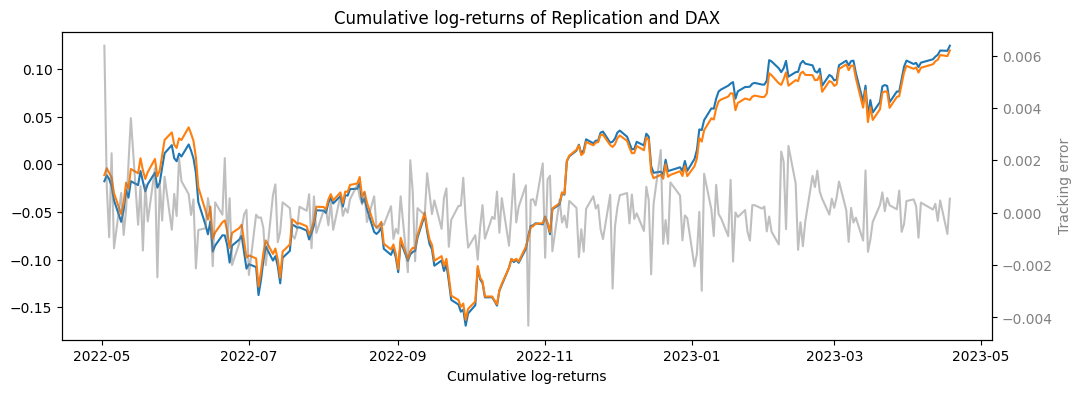

In [6]:
# Fit the model
fitted_model = sm.OLS(returns.iloc[::,0], returns.iloc[::,1:]).fit()
# The weights are simply the parameters from the linear model
weights_linreg = fitted_model.params
# Show results
print(fitted_model.summary())

# create the figure and subplots
fig, ax1 = plt.subplots(figsize=(12,4))
# create a second y-axis
ax2 = ax1.twinx()
# plot the data on the first y-axis
ax1.plot(np.log(1 + returns.iloc[:, 1:] @ weights_linreg).cumsum(), label='Replication')
ax1.plot(np.log(1 + returns.iloc[:, 0]).cumsum(), label='DAX')
ax1.set_xlabel('Cumulative log-returns')
# plot the data on the second y-axis
ax2.plot(returns.iloc[:, 0] - returns.iloc[:, 1:] @ weights_linreg, label='Error', color='grey', alpha=0.5)
ax2.set_ylabel('Tracking error', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
# set the title of the plot
plt.title('Cumulative log-returns of Replication and DAX')
# show the plot
plt.show()

### Task:

We want to create a ["smart-beta"](https://en.wikipedia.org/wiki/Smart_beta) strategy that replicates the DAX index returns using only a subset of its constituents. This is, maximize the fit of the model using only $3$ constituents. This process is similar to [feature selection](https://en.wikipedia.org/wiki/Feature_selection) in machine learning. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

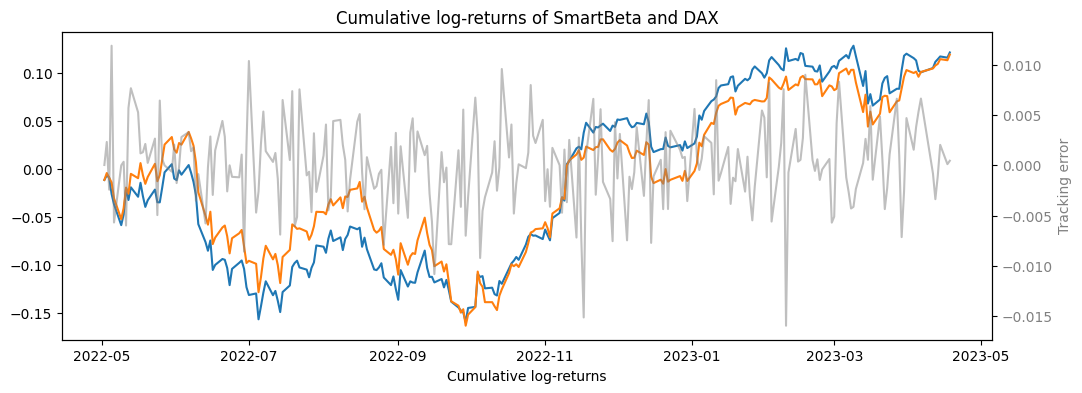

In [7]:
import itertools

# Potential constituents
constituent_tickers = prices.drop(columns='.GDAXI').columns
# get all combinations of 3 tickers
combinations = list(itertools.combinations(constituent_tickers, 3))

model_candidates = {}
for combination in combinations:
    # Get sample of constituents
    X = returns[list(combination)]
    # Fit the model
    fitted_model = sm.OLS(returns.iloc[::,0], X).fit()
    # Show results
    model_candidates[fitted_model.rsquared] = fitted_model.params

best_model = model_candidates[max(model_candidates.keys())]

# create the figure and subplots
fig, ax1 = plt.subplots(figsize=(12,4))
# create a second y-axis
ax2 = ax1.twinx()
# plot the data on the first y-axis
ax1.plot(np.log(1 + returns[best_model.keys()] @ best_model).cumsum(), label='Smart beta')
ax1.plot(np.log(1 + returns.iloc[:, 0]).cumsum(), label='DAX')
ax1.set_xlabel('Cumulative log-returns')
# plot the data on the second y-axis
ax2.plot(returns.iloc[:, 0] - returns[best_model.keys()] @ best_model, label='Error', color='grey', alpha=0.5)
ax2.set_ylabel('Tracking error', color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
# set the title of the plot
plt.title('Cumulative log-returns of SmartBeta and DAX')
# show the plot
plt.show()